In [1]:
# installing open datasets
!pip install opendatasets


In [2]:
import opendatasets as od

In [3]:
# Define path of dataset from kaggle
dataset ='https://www.kaggle.com/datasets/naiborhujosua/mosquito-on-human-skin'

In [4]:
# downloading dataset
od.download(dataset)

Skipping, found downloaded files in ".\mosquito-on-human-skin" (use force=True to force download)


In [5]:
# importing the libraries
import numpy as np
import os
import shutil
import random as rn
from tqdm import tqdm
import matplotlib.pyplot as plt

In [6]:
# assigning dataset path to variable
dataset_dir ='mosquito-on-human-skin/zw4p9kj6nt-2'

In [7]:
#printing list of classes in dataset
print(os.listdir(dataset_dir))

['Aedes  albopictus landing', 'Aedes aegypti landing', 'Aedes aegypti smashed', 'Aedes albopictus smashed', 'Culex quinquefasciatus landing', 'Culex quinquefasciatus smashed', 'data_splitting']


In [8]:
# defining parameters
batch_size = 40
img_height = 180
img_width = 180

In [9]:
# installing tensorflow
!pip install --user tensorflow

In [10]:
#splitting training data
import tensorflow as tf
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11099 files belonging to 7 classes.
Using 8880 files for training.


In [11]:
# splitting validation data
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11099 files belonging to 7 classes.
Using 2219 files for validation.


In [12]:
# printing class names under train data
class_names = train_ds.class_names
print(class_names)

['Aedes  albopictus landing', 'Aedes aegypti landing', 'Aedes aegypti smashed', 'Aedes albopictus smashed', 'Culex quinquefasciatus landing', 'Culex quinquefasciatus smashed', 'data_splitting']


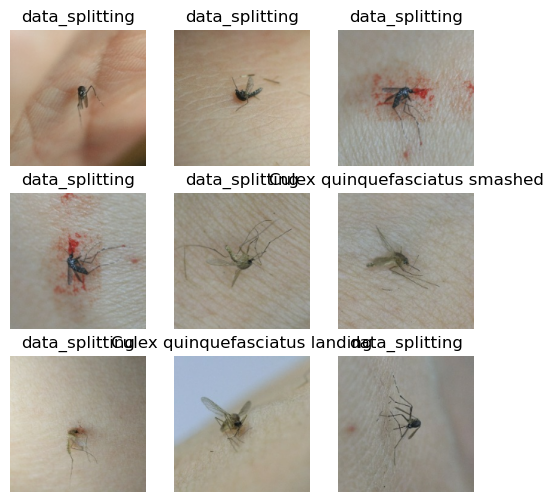

In [13]:
# data visualization : printing the images
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
#tensor of the shape
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(40, 180, 180, 3)
(40,)


In [15]:
#dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
#Standardize the data: normalization
from tensorflow.keras import layers
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.11978925 0.76119244


In [18]:
#Create the model
from keras.models import Sequential
num_classes = 7
model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

C:\Users\yarav\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
#compile the model:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics = ['accuracy'])

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,982,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,080,935 (7.94 MB)

 Trainable params: 2,080,935 (7.94 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 61s 255ms/step - accuracy: 0.8400 - loss: 0.7331 - val_accuracy: 0.8729 - val_loss: 0.5601
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 59s 266ms/step - accuracy: 0.8646 - loss: 0.5551 - val_accuracy: 0.8729 - val_loss: 0.4995
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 72s 326ms/step - accuracy: 0.8591 - loss: 0.5251 - val_accuracy: 0.8671 - val_loss: 0.4781
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 61s 276ms/step - accuracy: 0.8608 - loss: 0.4821 - val_accuracy: 0.8716 - val_loss: 0.4704
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 57s 259ms/step - accuracy: 0.8665 - loss: 0.4390 - val_accuracy: 0.8684 - val_loss: 0.4555
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 58s 259ms/step - accuracy: 0.8599 - loss: 0.4464 - val_accuracy: 0.8589 - val_loss: 0.4651
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 61s 276ms/step - accuracy: 0.8580 - loss: 0.4088 - val_accuracy: 0.8594 - val_loss: 0.4556
Epoch 8/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 57s 258ms/step - accuracy: 0.8459 - loss: 0

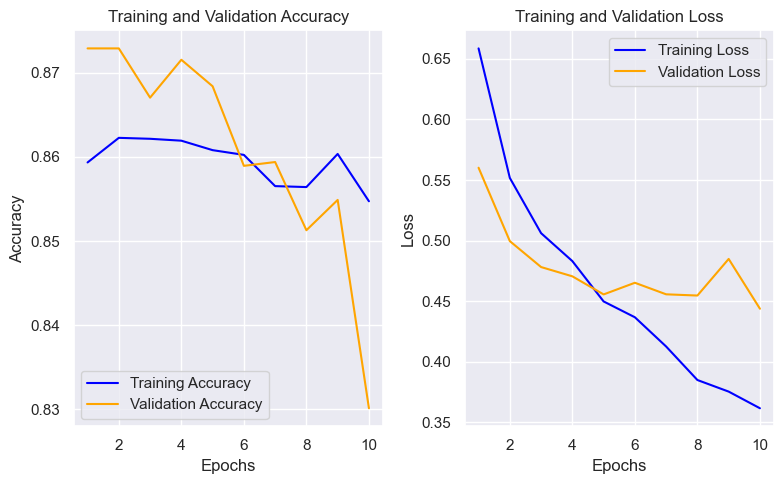

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(loss) + 1)  # Use the length of loss or acc

# Plot training and validation accuracy
plt.figure(figsize=(8, 5))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [30]:
#loss and accuracy of train dataset
loss,accuracy = model.evaluate(train_ds)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")     

222/222 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - accuracy: 0.8621 - loss: 0.6174
Loss: 0.6072311401367188
Accuracy: 0.8627251982688904


In [31]:
#loss and accuracy of validation dataset
loss,accuracy = model.evaluate(validation_ds)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")  

56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.8726 - loss: 0.5735
Loss: 0.5760531425476074
Accuracy: 0.8729157447814941


In [32]:
#possibile probability
y_pred_probabilities = model.predict(train_ds)
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)
y_pred_classes[:15]

222/222 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step


array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=int64)

In [36]:
from sklearn.metrics import classification_report
import numpy as np

# Define your class names
class_names = ['Aedes albopictus landing', 'Aedes aegypti landing', 'Aedes aegypti smashed', 'Aedes albopictus smashed', 'Culex quinquefasciatus landing', 'Culex quinquefasciatus smashed', 'data_splitting']

# Get true labels from the validation dataset
true_labels = []
for images, labels in validation_ds:
    true_labels.extend(labels.numpy())

true_labels = np.array(true_labels)

# Obtain predicted labels
y_pred_probabilities = model.predict(validation_ds)
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)

# Print classification report with zero_division parameter
print(classification_report(true_labels, y_pred_classes, target_names=class_names, zero_division=1))


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step
                                precision    recall  f1-score   support

      Aedes albopictus landing       1.00      0.00      0.00        51
         Aedes aegypti landing       1.00      0.00      0.00        50
         Aedes aegypti smashed       1.00      0.00      0.00        48
      Aedes albopictus smashed       1.00      0.00      0.00        40
Culex quinquefasciatus landing       1.00      0.00      0.00        46
Culex quinquefasciatus smashed       1.00      0.00      0.00        47
                data_splitting       0.87      1.00      0.93      1937

                      accuracy                           0.87      2219
                     macro avg       0.98      0.14      0.13      2219
                  weighted avg       0.89      0.87      0.81      2219



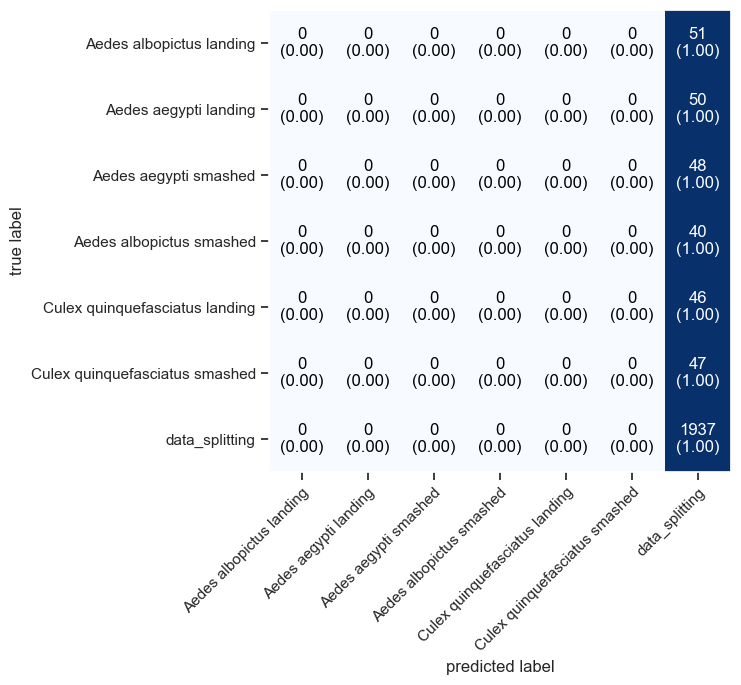

In [38]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, y_pred_classes)

# Plot confusion matrix
plot_confusion_matrix(conf_mat=conf_matrix, figsize=(8, 6), class_names=class_names, show_normed=True)
plt.show()